# Estimate the economic value of the clicks

In [1]:
import pyspark
import re
import pyspark.sql
from pyspark.sql import *
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import os.path
from pyspark.sql.functions import *
from datetime import timedelta, date
import json
from pyspark.sql.types import *
import sys
import urllib.parse
import builtins
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pyspark.ml.feature import CountVectorizer
import numpy as np

%matplotlib inline
spark = sqlContext = SQLContext(sc)

Load the estimate cost for the websites:

In [2]:
forecasts = pd.read_json("forecasts_last.json", lines=True).sample(frac=1.0)
forecasts.head()

,average_cpc,domain,keywords,link_url,title
3567,490132.921,www.michaelball.co.uk,[{'id': 'customers/6244703025/keywordPlanKeywo...,http://www.michaelball.co.uk/,Michael Ball
1506,447018.031,www.95triplex.com,[{'id': 'customers/6244703025/keywordPlanKeywo...,http://www.95triplex.com/,WXXX
3582,603282.429,questvisual.com,[{'id': 'customers/6244703025/keywordPlanKeywo...,http://questvisual.com/,Word Lens
1420,497872.021,npb.jp,[{'id': 'customers/6244703025/keywordPlanKeywo...,http://npb.jp/eng/,Nippon Professional Baseball
2887,1862515.720,www.gop.com,[{'id': 'customers/6244703025/keywordPlanKeywo...,https://www.gop.com/,Republican Party (United States)


In [3]:
len(forecasts)

3645

Merge with the actual number of clicks to get a weighted estimation:

In [4]:
forecasts_df = spark.createDataFrame(forecasts)

filter_30_days = "event_time >= '2019-03-24' AND event_time <= '2019-04-20' AND page_id > 0"

# Load click logs
anonymous_citationusage = spark.read.parquet("april_anonymous_citationusage.parquet")\
                                            .where(filter_30_days)\
                                            .where("action='extClick' and link_url not like '%.wikipedia.org%'")

clicks_count = anonymous_citationusage.groupBy("link_url")\
                    .agg(count("*").alias("total_clicks"))\
                    .sort(col("total_clicks").desc())

links = clicks_count.join(forecasts_df, "link_url").cache()
links.show()

+--------------------+------------+------------------+--------------------+--------------------+--------------------+
|            link_url|total_clicks|       average_cpc|              domain|            keywords|               title|
+--------------------+------------+------------------+--------------------+--------------------+--------------------+
|http://erwinmcman...|         208|1742069.7921111502|    erwinmcmanus.com|[[clicks -> 10.04...|       Erwin McManus|
|http://nudes-a-po...|         608|1243357.9990415382|  nudes-a-poppin.com|[[clicks -> 9.183...|     Nudes-A-Poppin'|
|http://www.asiaca...|        1389|273810.36296203325| www.asiacarrera.com|[[clicks -> 0.0, ...|        Asia Carrera|
|http://www.dhamma...|         214| 557774.1202156399|      www.dhamma.org|[[clicks -> 37.10...|        S. N. Goenka|
|http://www.fudan....|         227|  4639365.75351472|    www.fudan.edu.cn|[[clicks -> 26575...|    Fudan University|
|http://www.johnny...|         289|1169302.3384790602|ww

In [5]:
cpc = links.select("link_url", "total_clicks", "average_cpc").toPandas()

Get the total number of clicks represented by the domains in the sample:

In [6]:
cpc['total_clicks'].sum()

2738342

Get the total cost for each link:

In [7]:
cpc['total'] = cpc['total_clicks']*cpc['average_cpc']

Total value of the links in this sample:

In [8]:
print("${}".format(cpc.total.sum()/1000000))

$3774343.3661565674


In [9]:
cpc['in_dollars'] = cpc['average_cpc'].apply(lambda r: r/1000000)
cpc['in_dollars_str'] = cpc['average_cpc'].apply(lambda r: "${:.2}".format(r/1000000))
cpc['total_in_dollars'] = cpc['total'].apply(lambda r: r//1000000)
cpc['total_in_dollars_str'] = cpc['total'].apply(lambda r: "${}".format(r//1000000))


cpc[['link_url', 'total_clicks', 'in_dollars_str', 'total_in_dollars_str']].head(10)

,link_url,total_clicks,in_dollars_str,total_in_dollars_str
0,http://erwinmcmanus.com/,208,$1.7,$362.0
1,http://nudes-a-poppin.com/nap2010new/,608,$1.2,$755.0
2,http://www.asiacarrera.com/,1389,$0.27,$380.0
3,http://www.dhamma.org/en/,214,$0.56,$119.0
4,http://www.fudan.edu.cn/,227,$4.6,$1053.0
5,http://www.johnnymathis.com/,289,$1.2,$337.0
6,http://www.loewshotels.com/Portofino-Bay-Hotel,323,$1.6,$526.0
7,http://www.nhm.ac.uk/,223,$1.1,$234.0
8,http://www.nileinternational.net/,30,$1.8,$53.0
9,http://www.sabic.com/,248,$1.1,$282.0


Get weighted mean:

In [10]:
all_clicks = []
for i, r in cpc.iterrows():
    for c in range(0, r.total_clicks):
        all_clicks.append(r.average_cpc)
        
weighted_median = np.median(all_clicks)/1000000
weighted_mean = np.mean(all_clicks)/1000000

print("W Mean: ${}".format(cpc.average_cpc.mean()))
print("W Median: ${}".format(cpc.average_cpc.median()))

W Mean: $1647913.9061034522
W Median: $903399.9178036167


Plot the distribution:

<Figure size 360x216 with 0 Axes>

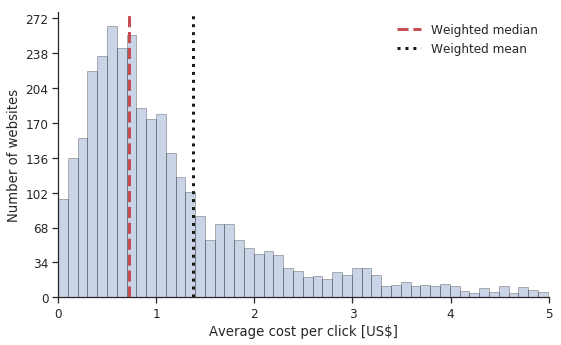

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns
from matplotlib.lines import Line2D

plt.figure(figsize=(5, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

# n = 100000
samples = cpc[cpc.in_dollars<5].in_dollars

# generate some random multimodal histogram data
h,e = np.histogram(samples, bins=50, density=True)
hnn,enn = np.histogram(samples, bins=50)
x = np.linspace(e.min(), e.max())

# plot the histogram
plt.figure(figsize=(8,5))
plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram', alpha=0.3)

plt.ylabel("Number of websites")
plt.xlabel("Average cost per click [US$]")

plt.axvline(x=weighted_mean, c="k", linestyle=":", linewidth=3)
plt.axvline(x=weighted_median, c="r", linestyle="--", linewidth=3)


max_val = int((builtins.max(hnn)/builtins.max(h))*0.8)
steps = [x/10 for x in range(0, 9)]
plt.yticks(steps, [x for x in range(0, max_val, max_val//(len(steps)-1))])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(0,5)


custom_lines = [Line2D([0], [0], color='r', lw=3, linestyle="--"),
                Line2D([0], [0], color='k', lw=3, linestyle=":")]
ax.legend(custom_lines, ['Weighted median', 'Weighted mean'], 
              fancybox=True, framealpha=0.0)

plt.tight_layout()
# plt.savefig('cost_per_click3000.pdf', bbox_inches='tight')

plt.show()